### Importing the Dataset

In [1]:
import numpy as np
import pandas as pd
import keras

posts = pd.read_csv("../data/Suicide_Detection.csv")
posts.drop(["Unnamed: 0"], axis=1, inplace=True)
posts[["class"]] = (posts[["class"]] == "suicide").astype("int16")

In [2]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[]

### Exploring the Dataset

In [3]:
posts.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [4]:
posts.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [5]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42)

#### Analyzing the Dataset

In [6]:
posts = strat_train_set.copy()
posts.head()

,text,class
186835,I don’t want to deal with this anymoreThere is...,1
216937,Bf thinks I am cheatingToday instead of waking...,1
176846,I hate myself...and I'm beginning to think eve...,1
49653,confession time s1eo5 about 9 years ago i stuc...,0
69140,"After years of contemplation, I'm ready.**This...",1


In [7]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [8]:
post_lengths[:10]

[231, 51, 102, 17, 1013, 156, 58, 34, 319, 39]

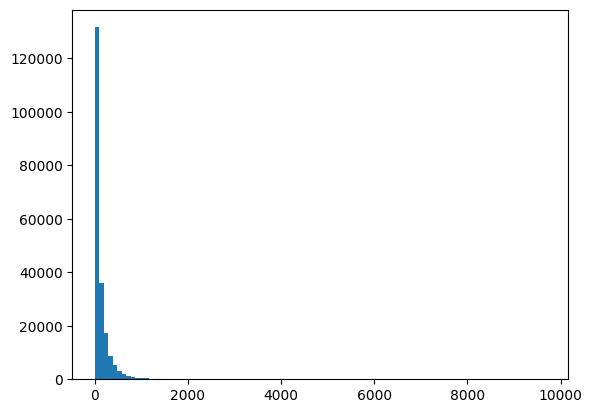

In [9]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

#### Spliting the dataset (again)

In [10]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=1)

strat_train_set[:5]

,text,class
185289,Need some advice I’d appreciate if people won’...,0
135507,"Dear Magic Eye Bot I hate you,\nI never wanna ...",0
213617,If there's any teachers in this sub Why do you...,0
137338,I am now officially closer to 30 years of age ...,0
20632,Sure the royal family racism thing is interest...,0


#### Tokenizing the posts

In [15]:
import spacy
spacy.require_gpu()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [16]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [17]:
def preprocess_set(set):
    texts = set.copy()['text']
    labels = set.copy()['class']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in docs:
        lemmas = [token.lemma_ for token in doc if not token.is_punct]
        processed_texts.append(' '.join(lemmas))
    
    return processed_texts, labels

In [18]:
processed_texts, labels = preprocess_set(strat_train_set)

In [19]:
processed_val_texts, val_labels = preprocess_set(strat_val_set)

#### Creating the Tokenizer

In [20]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=3000, oov_token='<UNK>')
tokenizer.fit_on_texts(processed_texts)

In [21]:
sequences = tokenizer.texts_to_sequences(processed_texts)

In [22]:
sequence_lengths = [len(sequence) for sequence in sequences if len(sequence) < 1000]

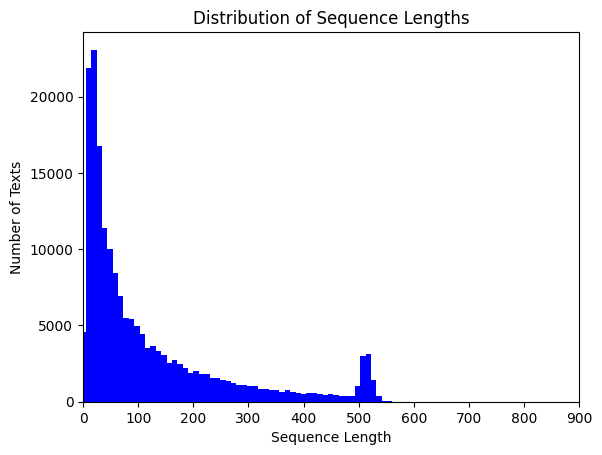

In [23]:
plt.hist(sequence_lengths, bins=100, color='blue', align='left')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Texts')
plt.title('Distribution of Sequence Lengths')
plt.xlim(0, 200)
plt.xticks(range(0, max(sequence_lengths) + 1, 100))
plt.show()

In [24]:
from keras.preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, processed_texts)
train_labels = np.array(labels)

In [25]:
word_index = tokenizer.word_index

sorted(word_index.items(), key=lambda x: x[1])[:10]

[('<UNK>', 1),
 ('i', 2),
 ('be', 3),
 ('to', 4),
 ('and', 5),
 ('the', 6),
 ('not', 7),
 ('a', 8),
 ('my', 9),
 ('do', 10)]

#### Creating the model

In [70]:
Sequential = keras.models.Sequential
from keras_tuner import HyperParameters as hp
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential([
            keras.layers.Embedding(3000, 16),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10), return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10))),
        keras.layers.Dense(2, activation = hp.Choice('activation', ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu']))
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

### Random Search

In [71]:
tuner = RandomSearch(
	build_model,
	objective='val_accuracy',
	max_trials=3,
	executions_per_trial=1,
	directory='../runs',
	project_name='iubdc-1'
)

In [74]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu'], 'ordered': False}


In [75]:
val_seq = get_sequences(tokenizer, processed_val_texts)
val_labels = np.array(val_labels)

tuner.search(padded_train_seq, train_labels, epochs=5, validation_data=(val_seq, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Trial 3 Complete [00h 15m 22s]
val_accuracy: 0.4888831377029419

Best val_accuracy So Far: 0.939805269241333
Total elapsed time: 00h 56m 48s


In [76]:
tuner.results_summary()

Results summary
Results in ../runs\iubdc-1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units: 10
activation: hard_sigmoid
Score: 0.939805269241333

Trial 1 summary
Hyperparameters:
units: 20
activation: hard_sigmoid
Score: 0.93459153175354

Trial 2 summary
Hyperparameters:
units: 20
activation: leaky_relu
Score: 0.4888831377029419


### Evaluating the Model

In [78]:
best_model = tuner.get_best_models(num_models=1)
best_model = best_model[0]
best_model.summary()

c:\Users\Qiuyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 20)        │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20)             │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,682 (205.79 KB)

 Trainable params: 52,682 (205.79 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
test_texts = strat_test_set.copy()['text']
test_labels = strat_test_set.copy()['class']

test_docs = (doc for doc in (nlp.pipe(test_texts)))
processed_test_texts = []
for doc in test_docs:
    lemmas = [token.lemma_ for token in doc]
    processed_test_texts.append(' '.join(lemmas))

test_seq = get_sequences(tokenizer, test_texts)
test_labels = np.array(test_labels)

In [81]:
test_seq, test_labels

(array([[   2, 2180,   32, ...,    0,    0,    0],
        [   2,   11,    4, ...,    0,    0,    0],
        [   8, 2235,    1, ...,    0,    0,    0],
        ...,
        [ 735,    1, 2408, ...,    0,    0,    0],
        [   1,  159,    6, ...,    0,    0,    0],
        [  12,    1,   50, ...,    0,    0,    0]]),
 array([1, 0, 0, ..., 0, 1, 1], dtype=int16))

In [82]:
_ = best_model.evaluate(test_seq, test_labels)

726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9056 - loss: 0.2844


In [83]:
y_pred = best_model.predict(test_seq)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[1], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


In [84]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.0898
False Negative Rate: 0.0997


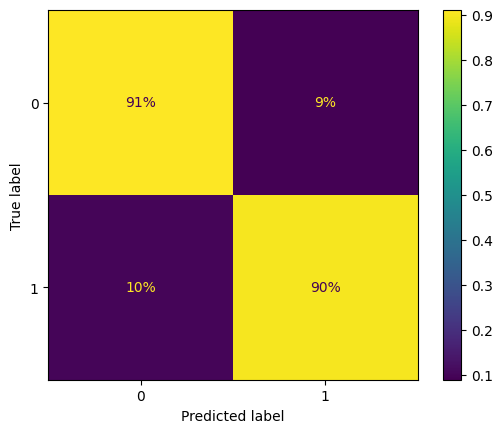

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()